# OAE Atlas Dataset

This notebook downloads a curated subset of the Ocean Carbon Dioxide Removal (OAE) Atlas dataset to a local cache using the S3 access helpers in `cdr_atlas.py`. It also provides quick visual checks and documentation of what is being downloaded.

Dataset hosted on Source Cooperative: https://source.coop/cworthy/oae-efficiency-atlas

## Dataset summary

- The dataset contains results from thousands of CESM ocean alkalinity enhancement simulations.
- Files are organized by polygon (region), injection month, and simulation year/month.
- Each experiment includes perturbation variables and counterfactual variables (suffix `_ALT_CO2`).
- Polygon masks and efficiency maps are provided as NetCDF files.

Use this notebook to prefetch data in batches to avoid repeated downloads during analysis.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import xarray as xr
import yaml

import atlas_engine

/global/homes/m/mattlong/.conda/envs/cson-atlas/lib/python3.13/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Configuration

Choose a polygon ID, injection month, and a set of model years to download. The files follow:

```
experiments/{polygon_id}/{injection_month}/alk-forcing.{polygon_id}-{injection_year}-{injection_month}.pop.h.{year}-{month}.nc
```

`polygon_id` ranges from 000–690 and `injection_month` is typically 01/04/07/10 for the published experiments. Use `n_test` to limit the number of files pulled.

Model year 0347 corresponds to the calendar year 1999, thus we need a `model_year_offset` to align the model calendar with the true calendar year.

:::{note}
`n_test = None` to download the full temporal dataset range of the datasets at the specified 
`polygon_id`, `injection_year`, `injection_month`. 

If all these parameters are `None`, all available data will be downloaded.
:::

In [2]:
batch_size = 50

 # set any to None to download all available
injection_year = 1999
injection_month = 1

# n_test limits the number of files downloaded
n_test = 2

dask_cluster_kwargs = {}


In [3]:
# Parameters
injection_year = 1999
injection_month = 1
n_test = None
dask_cluster_kwargs = {
    "account": "m4632",
    "queue_name": "premium",
    "n_nodes": 1,
    "n_tasks_per_node": 128,
    "wallclock": "06:00:00",
    "scheduler_file": None,
}


## Step 1: Identify files to download

We first enumerate all expected files for this polygon/time window. This avoids repeated S3 listings during computation.

In [4]:
atlas_data = atlas_engine.datasets["oae-efficiency-map_atlas-v0"]
atlas_data.df

s3_path  \
injection_year polygon_id injection_month year month                                                      
1999           0          1               347  1      s3://us-west-2.opendata.source.coop/cworthy/oa...   
                                               2      s3://us-west-2.opendata.source.coop/cworthy/oa...   
                                               3      s3://us-west-2.opendata.source.coop/cworthy/oa...   
                                               4      s3://us-west-2.opendata.source.coop/cworthy/oa...   
                                               5      s3://us-west-2.opendata.source.coop/cworthy/oa...   
...                                                                                                 ...   
               689        10              362  5      s3://us-west-2.opendata.source.coop/cworthy/oa...   
                                               6      s3://us-west-2.opendata.source.coop/cworthy/oa...   
                                               7      s3://us-west-2.opendata.source.coop/cworthy/oa...   
                                               8      s3://us-west-2.opendata.source.coop/cworthy/oa...   
                                               9      s3://us-west-2.opendata.source.coop/cworthy/oa...   

                                                                                             cache_path  
injection_year polygon_id injection_month year month                                                     
1999           0          1               347  1      /pscratch/sd/m/mattlong/atlas_cache/experiment...  
                                               2      /pscratch/sd/m/mattlong/atlas_cache/experiment...  
                                               3      /pscratch/sd/m/mattlong/atlas_cache/experiment...  
                                               4      /pscratch/sd/m/mattlong/atlas_cache/experiment...  
                                               5      /pscratch/sd/m/mattlong/atlas_cache/experiment...  
...                                                                                                 ...  
               689        10              362  5      /pscratch/sd/m/mattlong/atlas_cache/experiment...  
                                               6      /pscratch/sd/m/mattlong/atlas_cache/experiment...  
                                               7      /pscratch/sd/m/mattlong/atlas_cache/experiment...  
                                               8      /pscratch/sd/m/mattlong/atlas_cache/experiment...  
                                               9      /pscratch/sd/m/mattlong/atlas_cache/experiment...  

[496800 rows x 2 columns]

In [5]:
manifest = atlas_data.query(injection_year=injection_year, injection_month=injection_month, n_test=n_test)
manifest

,injection_year,polygon_id,injection_month,year,month,s3_path,cache_path
0,1999,0,1,347,1,s3://us-west-2.opendata.source.coop/cworthy/oa...,/pscratch/sd/m/mattlong/atlas_cache/experiment...
1,1999,0,1,347,2,s3://us-west-2.opendata.source.coop/cworthy/oa...,/pscratch/sd/m/mattlong/atlas_cache/experiment...
2,1999,0,1,347,3,s3://us-west-2.opendata.source.coop/cworthy/oa...,/pscratch/sd/m/mattlong/atlas_cache/experiment...
3,1999,0,1,347,4,s3://us-west-2.opendata.source.coop/cworthy/oa...,/pscratch/sd/m/mattlong/atlas_cache/experiment...
4,1999,0,1,347,5,s3://us-west-2.opendata.source.coop/cworthy/oa...,/pscratch/sd/m/mattlong/atlas_cache/experiment...
...,...,...,...,...,...,...,...
124195,1999,689,1,361,8,s3://us-west-2.opendata.source.coop/cworthy/oa...,/pscratch/sd/m/mattlong/atlas_cache/experiment...
124196,1999,689,1,361,9,s3://us-west-2.opendata.source.coop/cworthy/oa...,/pscratch/sd/m/mattlong/atlas_cache/experiment...
124197,1999,689,1,361,10,s3://us-west-2.opendata.source.coop/cworthy/oa...,/pscratch/sd/m/mattlong/atlas_cache/experiment...
124198,1999,689,1,361,11,s3://us-west-2.opendata.source.coop/cworthy/oa...,/pscratch/sd/m/mattlong/atlas_cache/experiment...


## Step 2: Download missing files in batches

Downloads happen in batches to reduce overhead and better utilize S3 transfer throughput.

In [6]:
downloaded = atlas_data.ensure_cache(injection_year=injection_year, injection_month=injection_month, n_test=n_test)

print(f"{len(downloaded)} file(s) in cache: {atlas_data.cache_dir}")

124200 file(s) in cache: /pscratch/sd/m/mattlong/atlas_cache


## Step 3: Open cached data and inspect variables

This uses the cached NetCDF files and avoids any further network transfer.

First, select a downloaded polygon.

In [7]:
polygon_id = atlas_data.query(injection_year=injection_year, injection_month=injection_month, n_test=n_test).polygon_id.unique()[0].item()
polygon_id

0

In [8]:
ds = atlas_data.open_dataset(polygon_id=polygon_id, injection_year=injection_year, injection_month=injection_month, n_test=n_test)
ds

<xarray.Dataset> Size: 55GB
Dimensions:                     (polygon_id: 1, injection_date: 1,
                                 elapsed_time: 180, z_t: 60, nlat: 384,
                                 nlon: 320, d2: 2, z_t_150m: 15, z_w: 60,
                                 z_w_top: 60, z_w_bot: 60)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 3kB dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    time                        (injection_date, elapsed_time) object 1kB dask.array<chunksize=(1, 1), meta=np.ndarray>
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time                (elapsed_time) timedelta64[ns] 1kB 0 days ......
Dimensions without coordinates: nlat, nlon, d2
Data variables: (12/34)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    co3_sat_calc                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    co3_sat_arag                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    ...                          ...
    ALK_ALT_CO2_zint_100m       (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
Attributes:
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

## Plot 1: Polygon mask overview

The polygon masks dataset defines the spatial regions used in the experiments. This plot previews the polygon IDs on the global grid.

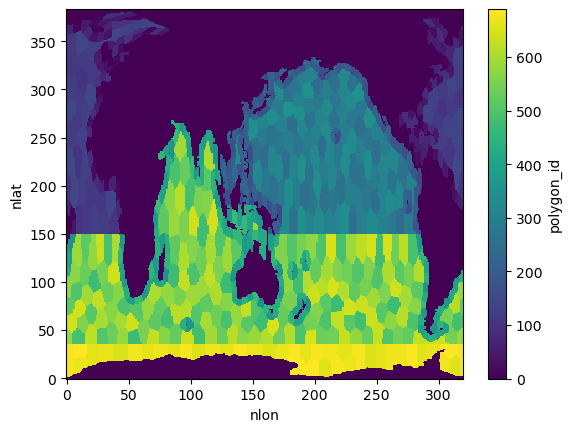

In [9]:
ds_atlas_polygons = atlas_data.get_polygon_masks_dataset()
polygon_ids = ds_atlas_polygons.polygon_id
polygon_ids.plot()

## Plot 2: Example FG_CO2 slice

The dataset includes FG_CO2 and FG_ALT_CO2 variables (perturbation vs. counterfactual). This plots one slice for the selected polygon and injection date.

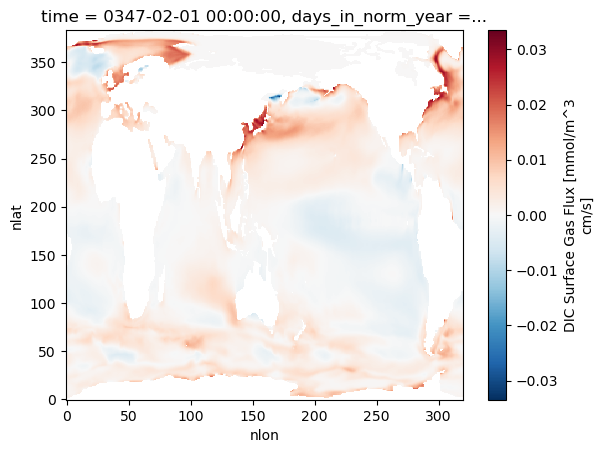

In [10]:
injection_date = f"{injection_year:04d}-{injection_month:02d}"

fg_co2 = ds.FG_CO2.sel(
    polygon_id=polygon_id, injection_date=injection_date
).isel(elapsed_time=0)

fg_co2.plot()

## Example 3: Subset to a ROMS-Tools grid

Use a ROMS-Tools grid YAML to find which atlas polygons intersect your model domain. This is a lightweight spatial filter that you can use before downloading or integrating data.

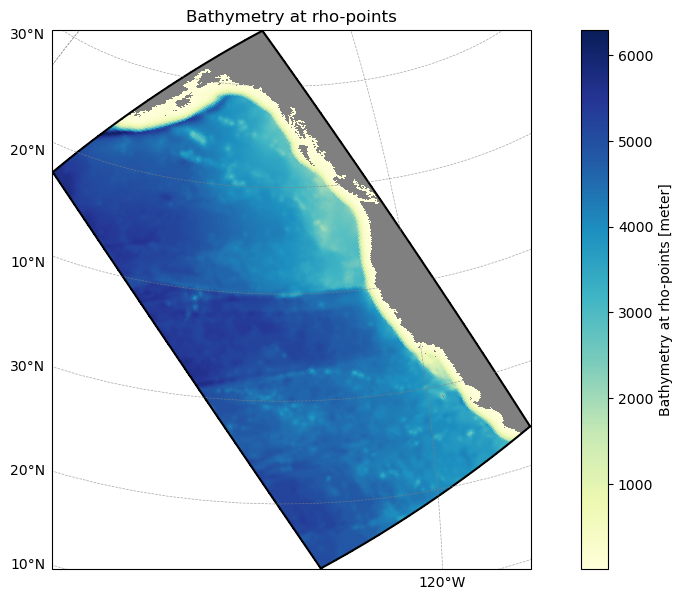

In [11]:
from atlas_engine.parsers import load_roms_tools_object

domain_name = "cson_roms-marbl_v0.1_ccs-12km"

# Path to a ROMS-Tools grid YAML
grid_yaml = f"../blueprints/{domain_name}/_grid.yml"
model_grid = load_roms_tools_object(grid_yaml)

model_grid.plot()


Found 34 unique polygon IDs within model grid boundaries
Polygon IDs: [152. 154. 159. 164. 167. 172. 180. 192. 194. 199. 201. 214. 219. 226.
 243. 244. 250. 259. 269. 270. 271. 276. 289. 290. 295. 299. 306. 320.
 324. 326. 328. 331. 345. 348.]


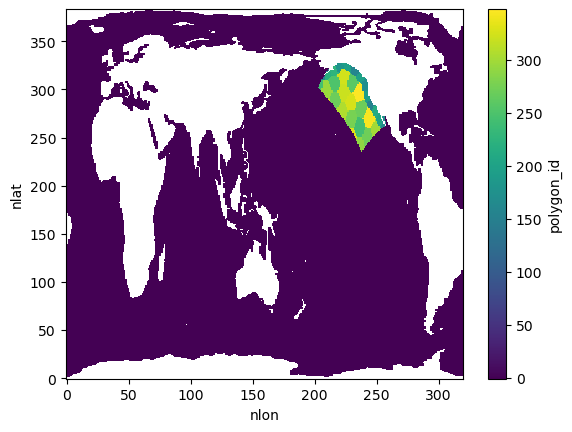

In [12]:
# Create AtlasModelGridAnalyzer instance
analyzer = atlas_engine.datasets["oae-efficiency-map_atlas-v0"].analyzer(model_grid)

# Get polygon IDs within model grid boundaries
print(f"Found {len(analyzer.polygon_ids_in_bounds)} unique polygon IDs within model grid boundaries")
print(f"Polygon IDs: {analyzer.polygon_ids_in_bounds[:100]}..." if len(analyzer.polygon_ids_in_bounds) > 100 else f"Polygon IDs: {analyzer.polygon_ids_in_bounds}")

analyzer.polygon_id_mask.plot(vmin=-1, vmax=analyzer.polygon_id_mask.max())